In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [2]:
DATA_DIR = "../../FoodHub/data"
classes = [dir for dir in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir))]
classes = sorted(classes)

classes

['apple',
 'banana',
 'beef',
 'bread',
 'broccoli',
 'butter',
 'carrot',
 'cheese',
 'chicken',
 'chocolate',
 'cinnamon',
 'corn',
 'cucumber',
 'egg',
 'eggplant',
 'fish',
 'garlic',
 'ginger',
 'lemon',
 'mushroom',
 'olives',
 'onion',
 'orange',
 'parsley',
 'pasta',
 'peas',
 'potato',
 'rice',
 'spinach',
 'tomato']

In [3]:
data = {
  class_name: len(os.listdir(os.path.join(DATA_DIR, class_name)))
  for class_name in classes
}

ingredients = list(data.keys())
images_count = list(data.values())

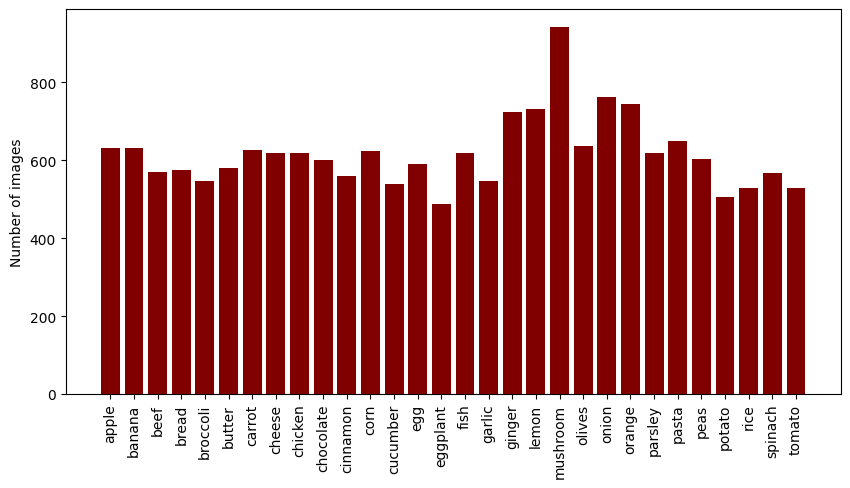

In [4]:
figure = plt.figure(figsize = (10, 5))

plt.bar(ingredients, images_count, color = "maroon")
plt.xticks(range(len(ingredients)), ingredients, rotation = "vertical")
plt.ylabel("Number of images")
plt.show()

In [5]:
training_data, validation_data = keras.utils.image_dataset_from_directory(
  DATA_DIR,
  labels = "inferred",
  label_mode = "int",
  class_names = classes,
  color_mode = "rgb",
  batch_size = 64,
  image_size = (224, 224),
  shuffle = True,
  validation_split = 0.1,
  subset = "both",
  seed = 42
)

Found 18517 files belonging to 30 classes.
Using 16666 files for training.
Using 1851 files for validation.


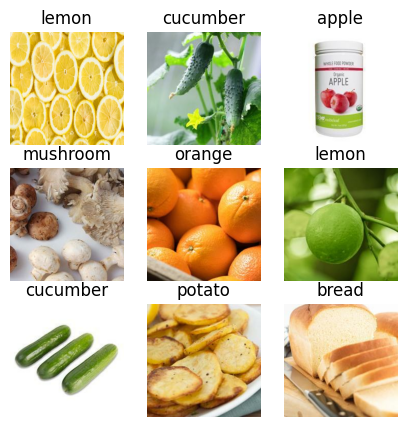

In [6]:
# 1 batch = 64 images
sample_data = list(training_data.take(1))

plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    # convert image to array of uint
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

Adjust brightness

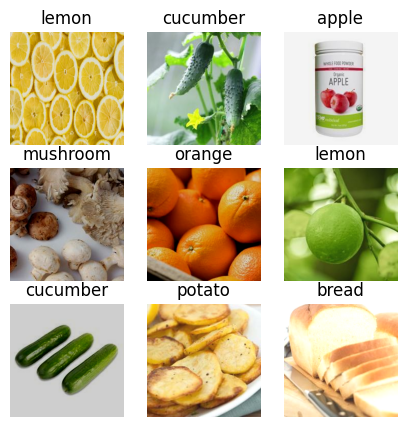

In [7]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    # uint8 = 0 - 255
    img = layers.RandomBrightness(factor = 0.2, value_range = (0, 255))(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

Flip images

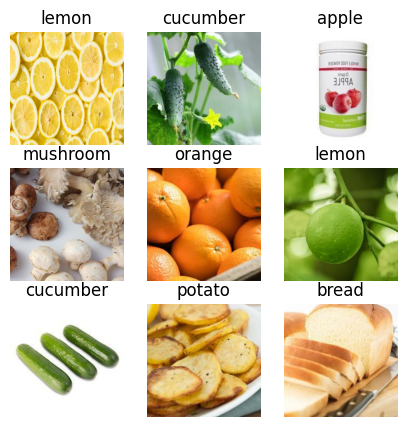

In [8]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    img = layers.RandomFlip("horizontal")(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

Rotate images

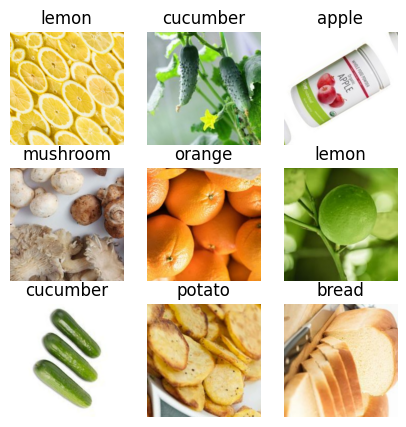

In [9]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    # 0.5 random rotates between -90 and +90 deg
    img = layers.RandomRotation(0.5)(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

Shuffle Colors

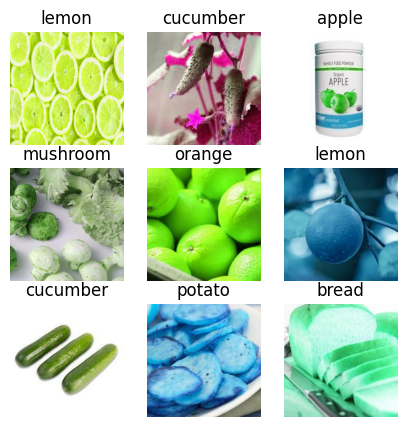

In [10]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    img = keras_cv.layers.ChannelShuffle()(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

Remove some pixels from images

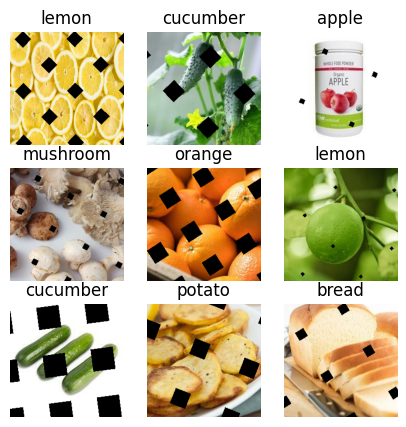

In [11]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    img = keras_cv.layers.GridMask()(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

In [ ]:
augmented_data = keras.Sequential(
  [
    layers.RandomBrightness(factor = 0.2, value_range = (0, 255)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.5),
    keras_cv.layers.ChannelShuffle(),
    keras_cv.layers.GridMask()
  ]
)

training_data = training_data.map(
  lambda image, label: (augmented_data(image), label),
  # allow parallel processing of images
  num_parallel_calls = tf.data.AUTOTUNE
)


training_data = training_data.prefetch(tf.data.AUTOTUNE)
validation_data= validation_data.prefetch(tf.data.AUTOTUNE)

In [22]:
# 0.00001
L2_LAMBDA = 1e-5

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)

  # 255 is the largest possible value
  x = layers.Rescaling(1.0 / 255)(inputs)
  
  # 32 filters, kernel size = 3
  x = layers.Conv2D(32, 3, strides = 1, padding = "same", kernel_regularizer = regularizers.L2(L2_LAMBDA))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("gelu")(x)

  x = layers.Conv2D(32, 3, strides = 1, padding = "same", kernel_regularizer = regularizers.L2(L2_LAMBDA))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("gelu")(x)
  
  x = layers.Conv2D(64, 3, strides = 2, padding = "same", kernel_regularizer = regularizers.L2(L2_LAMBDA))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("gelu")(x)

  for filters in [64, 128, 256, 512]:
    # 32 filters, kernel size = 3
    x = layers.Conv2D(filters, 3, strides = 1, padding = "same", kernel_regularizer = regularizers.L2(L2_LAMBDA))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)

    x = layers.Conv2D(filters, 3, strides = 1, padding = "same", kernel_regularizer = regularizers.L2(L2_LAMBDA))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)
    
    x = layers.Conv2D(filters, 3, strides = 1, padding = "same", kernel_regularizer = regularizers.L2(L2_LAMBDA))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)

    x = layers.MaxPooling2D(3, strides = 2)(x)

  x = layers.GlobalMaxPooling2D()(x)

  x = layers.Dense(256, activation = "gelu", activity_regularizer = regularizers.L2(L2_LAMBDA))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Dense(256, activation = "gelu", activity_regularizer = regularizers.L2(L2_LAMBDA))(x)
  x = layers.Dropout(0.2)(x)

  outputs = layers.Dense(num_classes, activation = "softmax")(x)

  return keras.Model(inputs, outputs)

In [23]:
# each pixel has 3 color channels = (224, 224, 3)
IMAGE_SIZE = (224, 224) + (3, )

model = make_model(input_shape = IMAGE_SIZE, num_classes = 30)

In [32]:
epochs = 30
callbacks = [
  keras.callbacks.ModelCheckpoint("03-dumps/epoch-{epoch}.keras")
]

In [33]:
# learning rate = 0.001
model.compile(
  optimizer = keras.optimizers.Adam(1e-3), 
  loss = "sparse_categorical_crossentropy",
  metrics = ["accuracy"]
)

In [34]:
model_output = model.fit(
  training_data,
  epochs = epochs,
  callbacks = callbacks,
  validation_data = validation_data
)

Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8175s 31s/step - accuracy: 0.0839 - loss: 3.2515 - val_accuracy: 0.0632 - val_loss: 7.0968
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8075s 31s/step - accuracy: 0.1051 - loss: 3.1181 - val_accuracy: 0.0859 - val_loss: 3.7787
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8014s 31s/step - accuracy: 0.1280 - loss: 3.0080 - val_accuracy: 0.0800 - val_loss: 3.5789
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8610s 33s/step - accuracy: 0.1484 - loss: 2.9322 - val_accuracy: 0.1410 - val_loss: 2.9825
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8732s 33s/step - accuracy: 0.1715 - loss: 2.8311 - val_accuracy: 0.1415 - val_loss: 3.3301
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7863s 30s/step - accuracy: 0.2028 - loss: 2.7433 - val_accuracy: 0.2075 - val_loss: 2.7173
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8427s 32s/step - accuracy: 0.2182 - loss: 2.7081 - val_accuracy: 0.2004 - val_loss: 2.7779
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 10417s 40s/step - accuracy: 0.2357 - loss: 

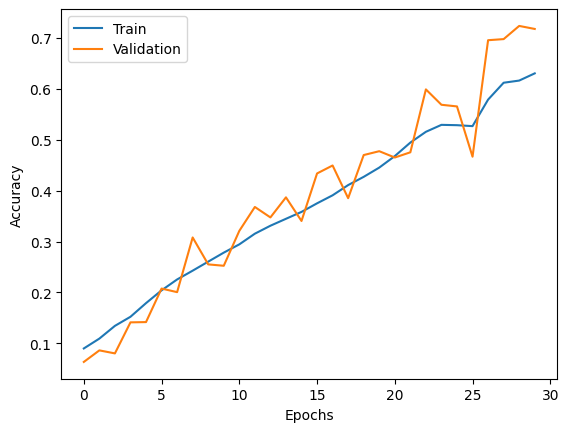

In [35]:
plt.plot(model_output.history["accuracy"], label = "Train")
plt.plot(model_output.history["val_accuracy"], label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

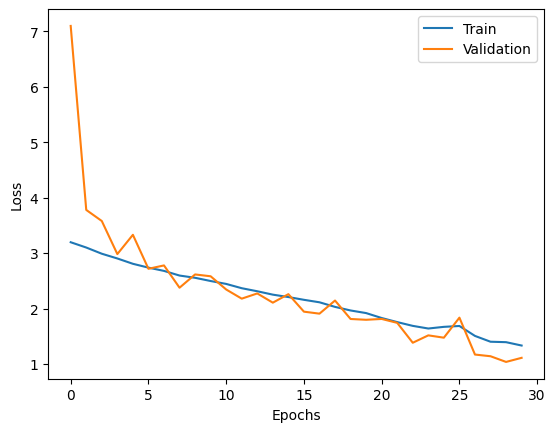

In [36]:
plt.plot(model_output.history["loss"], label = "Train")
plt.plot(model_output.history["val_loss"], label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
loaded_model = keras.models.load_model("03-dumps/epoch-30.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

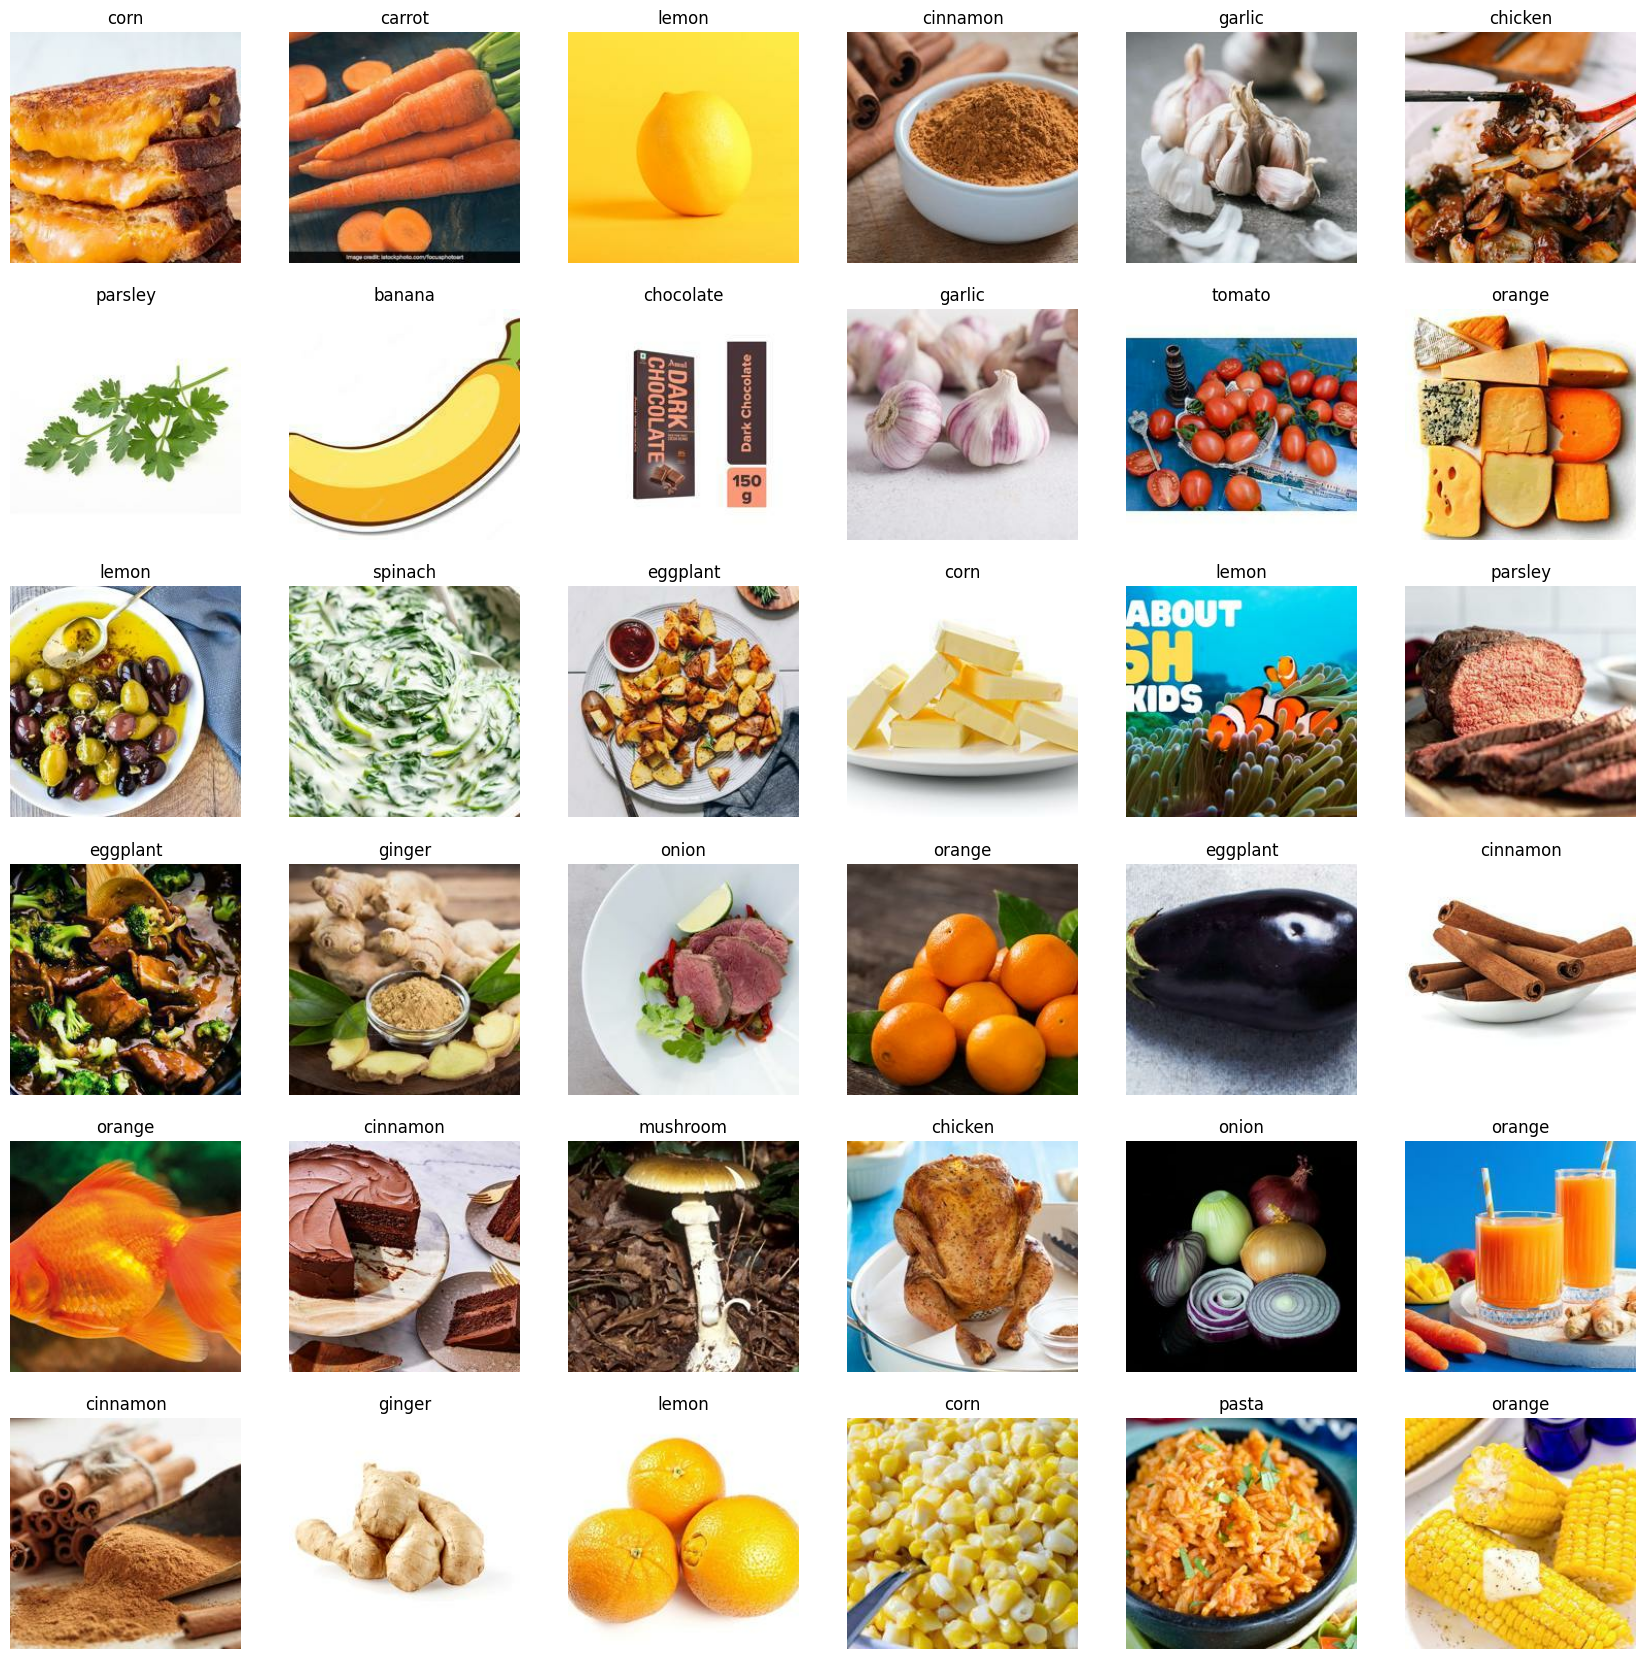

In [39]:
plt.figure(figsize = (21, 21))

for images, labels in validation_data.take(1):
  for i in range(36):
    axes = plt.subplot(6, 6, i + 1)
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
    img_array = tf.expand_dims(img, 0)
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    plt.title(classes[predicted_class])
    plt.axis("off")